# San Antonio 311 service calls

Goals: 
- Explore service calls that San Antonio receives
    - Determine if certain areas have higher service calls requests, specifically by type
    - See which types of service calls have the longest service times



In [167]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [174]:
df = pd.read_csv("allservicecalls.csv")

In [175]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590016 entries, 0 to 590015
Data columns (total 17 columns):
Category                590016 non-null object
CASEID                  590016 non-null int64
OPENEDDATETIME          590016 non-null object
SLA_Date                589959 non-null object
CLOSEDDATETIME          563276 non-null object
Late (Yes/No)           590016 non-null object
Dept                    589875 non-null object
REASONNAME              590016 non-null object
TYPENAME                590016 non-null object
CaseStatus              590016 non-null object
SourceID                590016 non-null object
OBJECTDESC              590016 non-null object
Council District        590016 non-null int64
XCOORD                  590016 non-null int64
YCOORD                  590016 non-null int64
Report Starting Date    590016 non-null object
Report Ending Date      590016 non-null object
dtypes: int64(4), object(13)
memory usage: 76.5+ MB


,Category,CASEID,OPENEDDATETIME,SLA_Date,CLOSEDDATETIME,Late (Yes/No),Dept,REASONNAME,TYPENAME,CaseStatus,SourceID,OBJECTDESC,Council District,XCOORD,YCOORD,Report Starting Date,Report Ending Date
0,Information,1010056445,10/18/2011,10/27/2011,11/14/2018,YES,Customer Service,311 Call Center,Customer Satisfaction,Closed,Web Portal,"19399 NW MILITARY HY, San Antonio, 78257",8,2104251,13774290,11/9/2018,11/9/2019
1,Information,1010058206,10/19/2011,10/28/2011,11/14/2018,YES,Customer Service,311 Call Center,Customer Satisfaction,Closed,Web Portal,"19399 NW MILITARY HY, San Antonio, 78257",8,2104251,13774290,11/9/2018,11/9/2019
2,Information,1010075875,10/31/2011,11/10/2011,11/14/2018,YES,Customer Service,311 Call Center,Customer Satisfaction,Closed,Web Portal,"1106 ELLISON DR S, San Antonio, 78245",4,2070537,13702644,11/9/2018,11/9/2019
3,Information,1010115259,12/1/2011,12/13/2011,11/14/2018,YES,Customer Service,311 Call Center,Customer Satisfaction,Closed,Web Portal,PLAZA DE ARMAS and COMMERCE ST W,1,2129213,13702278,11/9/2018,11/9/2019
4,Streets & Infrastructure,1010126853,12/10/2011,12/11/2011,NaN,YES,Trans & Cap Improvements,Storm Water,Tree Fallen,Open,Constituent Call,ELM CREEK and WURZBACH RD,8,2113584,13747492,11/9/2018,11/9/2019


#### Downloaded the data dictionary provided by the great city of San Antonio

In [176]:
data_dict = pd.read_csv("datadict.csv")
data_dict

,column,type,label,description
0,Category,text,CATEGORY,This general category was developed to place 3...
1,CASEID,text,CASEID,The unique case reference number is assigned b...
2,OPENEDDATETIME,timestamp,OPENEDDATETIME,The date and time that a case was submitted.\r\n
3,SLA_Date,timestamp,SLA_Date,Every service request type has a due date assi...
4,CLOSEDDATETIME,timestamp,CLOSEDDATETIME,The date and time that the case/request was wa...
5,Late (Yes/No),text,Late (Yes/No),This indicates whether the case has surpassed ...
6,Dept,text,Dept,The City department to whom the case is assign...
7,REASONNAME,text,REASONNAME,The department division within the City deaprt...
8,TYPENAME,text,TYPENAME,The service request type name for the issue be...
9,CaseStatus,text,CaseStatus,The status of a case which is either open or c...


In [177]:
# print descriptions for easier viewing
for x  in data_dict.description:
    print(x)

This general category was developed to place 311 services in a high level category, different than their respective department.

The unique case reference number is assigned by the 311 Lagan customer relationship management system.

The date and time that a case was submitted.

Every service request type has a due date assigned to the request, based on the request type name.  The SLA Date is the due date and time for the request type based on the service level agreement (SLA).  Each service request type has a timeframe in which it is scheduled to be addressed.

The date and time that the case/request was was closed.  If blank, the request has not been closed as of the Report Ending Date.

This indicates whether the case has surpassed its Service Level Agreement due date for the specific service request.

The City department to whom the case is assigned.

The department division within the City deaprtment to whom the case is assigned.

The service request type name for the issue being r

## Prepare

#### Check for nulls and address them appropriately 

In [178]:
df.isnull().sum()

Category                    0
CASEID                      0
OPENEDDATETIME              0
SLA_Date                   57
CLOSEDDATETIME          26740
Late (Yes/No)               0
Dept                      141
REASONNAME                  0
TYPENAME                    0
CaseStatus                  0
SourceID                    0
OBJECTDESC                  0
Council District            0
XCOORD                      0
YCOORD                      0
Report Starting Date        0
Report Ending Date          0
dtype: int64

Nulls to address
- `SLA_Date` is the due date of the service request. Why are there nulls? Are there certain service request types that don't require a due date? Need to explore more. 
- `CLOSEDDATTIME` has nulls, as they are still open cases. Will replace with placeholder "open". 
- `Dept` states which department the case is assigned. Do some cases not get assigned? Did they fall in a crack? Are they too new and haven't been assigned a department yet? 

>Will explore data more to better understand how to address nulls for `SLA_Date` and `Dept`

#### Rename columns for understandabilty and ease of typing

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590016 entries, 0 to 590015
Data columns (total 17 columns):
Category                590016 non-null object
CASEID                  590016 non-null int64
OPENEDDATETIME          590016 non-null object
SLA_Date                589959 non-null object
CLOSEDDATETIME          563276 non-null object
Late (Yes/No)           590016 non-null object
Dept                    589875 non-null object
REASONNAME              590016 non-null object
TYPENAME                590016 non-null object
CaseStatus              590016 non-null object
SourceID                590016 non-null object
OBJECTDESC              590016 non-null object
Council District        590016 non-null int64
XCOORD                  590016 non-null int64
YCOORD                  590016 non-null int64
Report Starting Date    590016 non-null object
Report Ending Date      590016 non-null object
dtypes: int64(4), object(13)
memory usage: 76.5+ MB


In [180]:
df.rename(columns={"Category":"category","CASEID":"id","OPENEDDATETIME":"open_date","SLA_Date":"due_date",
                   "CLOSEDDATETIME":"close_date", "Late (Yes/No)":"late", "Dept":"dept", "REASONNAME":"city_department",
                  "TYPENAME":"department_division","CaseStatus":"status","SourceID":"source","OBJECTDESC":"location",
                  "Council District":"district_no","XCOORD":"x_cord","YCOORD":"y_cord","Report Starting Date":"start_date",
                  "Report Ending Date":"end_date"}, inplace=True)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590016 entries, 0 to 590015
Data columns (total 17 columns):
category               590016 non-null object
id                     590016 non-null int64
open_date              590016 non-null object
due_date               589959 non-null object
close_date             563276 non-null object
late                   590016 non-null object
dept                   589875 non-null object
city_department        590016 non-null object
department_division    590016 non-null object
status                 590016 non-null object
source                 590016 non-null object
location               590016 non-null object
district_no            590016 non-null int64
x_cord                 590016 non-null int64
y_cord                 590016 non-null int64
start_date             590016 non-null object
end_date               590016 non-null object
dtypes: int64(4), object(13)
memory usage: 76.5+ MB


#### Explore each column individually to better understand the data

In [182]:
df.category.value_counts()

Solid Waste Services         191656
Property Maintenance         190181
Animals                       80501
Streets & Infrastructure      45325
Traffic Signals and Signs     31036
Graffiti                      24652
Parks                         11808
No Category                    6326
Information                    4936
Health & Sanitation            3595
Name: category, dtype: int64

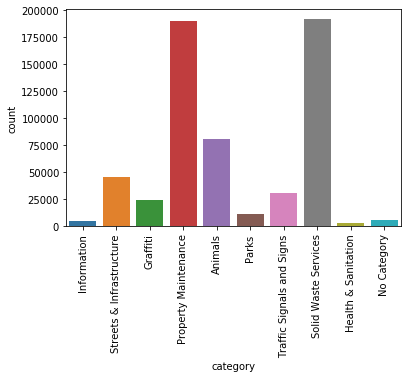

In [183]:
sns.countplot(df.category)
plt.xticks(rotation=90)
plt.show()

In [184]:
# the number of times each id number shows up
df.id.value_counts().value_counts()

1    589878
2        69
Name: id, dtype: int64

> There are some repeat id numbers. Was it the same case phone in twice? 

In [185]:
df.open_date = pd.to_datetime(df.open_date)

In [186]:
df.open_date.dt.year.value_counts()

2019    501827
2018     84523
2017      1627
2016       882
2014       646
2015       279
2013       193
2012        30
2011         9
Name: open_date, dtype: int64

In [187]:
df.open_date.dt.month.value_counts()

6     55041
5     54957
4     54249
7     53796
3     53293
10    51569
8     47045
9     46185
1     46033
2     45508
11    43693
12    38647
Name: open_date, dtype: int64

> As hoped for, most of the cases are current. Are certain types of cases more likely to go unresolved?

In [213]:
df [df.due_date.isnull()]

,category,id,open_date,due_date,close_date,late,dept,city_department,department_division,status,source,location,district_no,x_cord,y_cord,start_date,end_date
12,Information,1010164162,2012-01-14,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"7443 STONEHOUSE DR, San Antonio, 78227",6,2081547,13703752,11/9/2018,11/9/2019
24,Information,1010215530,2012-02-24,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"6644 TEZEL RD, San Antonio, 78250",6,2075887,13727715,11/9/2018,11/9/2019
27,Information,1010239554,2012-03-14,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"11818 THOROGHBRED TR, San Antonio, 78253",6,2056099,13717134,11/9/2018,11/9/2019
31,Information,1010248947,2012-03-21,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"7926 RUBY MEADOW, San Antonio, 78251",6,2080030,13715880,11/9/2018,11/9/2019
34,Information,1010316761,2012-05-09,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"6103 MILLBANK DR, San Antonio, 78238",6,2093813,13712133,11/9/2018,11/9/2019
35,Information,1010338011,2012-05-25,NaN,NaT,NO,Knowledge Management,Knowledge,Knowledge Solution Extra,Open,Constituent Call,"310 ROOSEVELT AV, San Antonio, 78210",5,2132295,13693603,11/9/2018,11/9/2019
36,Information,1010409270,2012-07-18,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"9034 RYELLE, San Antonio, 78250",6,2070829,13737531,11/9/2018,11/9/2019
37,Information,1010433538,2012-08-07,NaN,2019-02-11,NO,City Council,District 6,Request for Research/Information,Closed,Constituent Call,"8238 CREEKLINE DR, San Antonio, 78251",6,2079249,13717918,11/9/2018,11/9/2019
2703,Information,1013762220,2017-08-01,NaN,NaT,NO,City Council,District 6,Request for Research/Information,Open,Constituent Call,CULEBRA RD and VILLAGE PKWY,6,2079083,13719525,11/9/2018,11/9/2019
2784,Information,1013810864,2017-08-21,NaN,NaT,NO,City Council,District 9,Request for Research/Information,Open,Constituent Call,"1323 BLUE CREST LN, San Antonio, 78232",9,2135747,13752110,11/9/2018,11/9/2019


In [217]:
for x in df [df.due_date.isnull()].columns:
    print(x)
    print(df [df.due_date.isnull()][x].value_counts())
    print()

category
Information    57
Name: category, dtype: int64

id
1014443709    1
1014843973    1
1015764603    1
1014890431    1
1014598231    1
1015916858    1
1014573241    1
1010409270    1
1014498610    1
1015766828    1
1013810864    1
1013762220    1
1015718569    1
1015362854    1
1015018149    1
1015507108    1
1014397247    1
1015289312    1
1014499934    1
1014437272    1
1014795284    1
1014263058    1
1015641873    1
1014759588    1
1015643147    1
1014393735    1
1010433538    1
1010164162    1
1014606316    1
1014574075    1
1013855831    1
1014365560    1
1015023477    1
1014507508    1
1010248947    1
1015025137    1
1014493167    1
1015730414    1
1013867885    1
1014558316    1
1010215530    1
1015645208    1
1015764596    1
1010338011    1
1015339360    1
1014206419    1
1015640414    1
1013817308    1
1010239554    1
1015725274    1
1010316761    1
1014573272    1
1013939287    1
1015017555    1
1014493173    1
1015289419    1
1013940992    1
Name: id, dtype: int64

open

> All the `due_date` nulls are not considered late and appear to be routed to a specific district. Do city district calls never get a due date? 

In [238]:
df.dept.value_counts()

Code Enforcement Services    210271
Solid Waste Management       191656
Animal Care Services          81262
Trans & Cap Improvements      77705
Parks and Recreation          13348
Customer Service              10432
Metro Health                   3595
Development Services           1678
City Council                     56
Knowledge Management              1
Name: dept, dtype: int64

> All "City Council" calls do not get a due date. How should I address the nulls then? Delete them? Put a 'none' placeholder? Create a same-day due date? Will put 'none' for now.

In [259]:
df.due_date.replace(np.nan, "none", inplace=True)

In [260]:
df.due_date.isnull().sum()

0

> Will probably make a new column that gives the difference between start date and due date

In [239]:
df.close_date = pd.to_datetime(df.close_date)

In [240]:
df.close_date.dt.year.value_counts(dropna=False)

2019.0    496748
2018.0     66528
NaN        26740
Name: close_date, dtype: int64

In [241]:
df.close_date.dt.month.value_counts(dropna=False)

7.0     54492
5.0     54005
6.0     50992
4.0     50334
3.0     48836
8.0     47211
10.0    46837
1.0     45654
9.0     44507
2.0     42244
11.0    40837
12.0    37327
NaN     26740
Name: close_date, dtype: int64

> Might make separate dataframe with only the open cases. Still leaving in open cases in the original dataframe, replacing nulls with "open"

In [246]:
df_open_cases = df [df.close_date.isnull()]

In [247]:
df_open_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26740 entries, 4 to 590014
Data columns (total 17 columns):
category               26740 non-null object
id                     26740 non-null int64
open_date              26740 non-null datetime64[ns]
due_date               26690 non-null object
close_date             0 non-null datetime64[ns]
late                   26740 non-null object
dept                   26732 non-null object
city_department        26740 non-null object
department_division    26740 non-null object
status                 26740 non-null object
source                 26740 non-null object
location               26740 non-null object
district_no            26740 non-null int64
x_cord                 26740 non-null int64
y_cord                 26740 non-null int64
start_date             26740 non-null object
end_date               26740 non-null object
dtypes: datetime64[ns](2), int64(4), object(11)
memory usage: 3.7+ MB


In [202]:
df.late.value_counts()

NO     515259
YES     74757
Name: late, dtype: int64

> Explore which types of calls are late. Why are the late? Predict whether or not a call will be late?

In [203]:
df.dept.value_counts(dropna=False)

Code Enforcement Services    210142
Solid Waste Management       191656
Animal Care Services          81262
Trans & Cap Improvements      77705
Parks and Recreation          13348
Customer Service              10432
Metro Health                   3595
Development Services           1678
NaN                             141
City Council                     56
Knowledge Management              1
Name: dept, dtype: int64

In [204]:
df.city_department.value_counts(dropna=False)

Code Enforcement                 180981
Waste Collection                 147017
Field Operations                  81262
Streets                           31238
Miscellaneous                     29195
Signs and Markings                17011
Signals                           15620
Brush                             13946
Dangerous Premise                 10862
311 Call Center                   10432
Graffiti                          10307
Storm Water                        9971
Shops (Internal)                   9377
Graffiti (IntExp)                  7031
Traffic Engineering Design         3275
Food Establishments                2282
Trades                             2245
Engineering Division               1678
Solid Waste                        1498
Facility License                   1061
Code Enforcement (IntExp)           953
Clean and Green                     873
Tree Crew                           719
Storm Water Engineering             584
Vector                              252


> `city_department` is a subset of `dept`. It doens't make sense that `dept` would have nulls and `city_department` would not. Let's explore those.

In [205]:
# city_department values for the dept nulls
df [df.dept.isnull()].city_department.value_counts()

Code Enforcement (Internal)    129
Historic Preservation           12
Name: city_department, dtype: int64

In [206]:
df [df.dept == "Code Enforcement Services"].city_department.value_counts()

Code Enforcement              180981
Dangerous Premise              10862
Graffiti                       10307
Graffiti (IntExp)               7031
Code Enforcement (IntExp)        953
Dangerous Premise (IntExp)         8
Name: city_department, dtype: int64

> I believe all that the `dept` nulls can be filled with "Code Enforcement Services" for all the columns where the `city_department` is "Code Enforcement (Internal)"

In [207]:
df.dept [df.city_department == "Code Enforcement (Internal)"] = "Code Enforcement Services"

In [208]:
df.dept.value_counts(dropna=False)

Code Enforcement Services    210271
Solid Waste Management       191656
Animal Care Services          81262
Trans & Cap Improvements      77705
Parks and Recreation          13348
Customer Service              10432
Metro Health                   3595
Development Services           1678
City Council                     56
NaN                              12
Knowledge Management              1
Name: dept, dtype: int64

Determine which department "historical preservation" belongs in

In [209]:
for x in df.dept.unique():
    print(x)
    print("---")
    print(df [df.dept == x].city_department.value_counts())
    print()

Customer Service
---
311 Call Center    10432
Name: city_department, dtype: int64

Trans & Cap Improvements
---
Streets                         31238
Signs and Markings              17011
Signals                         15620
Storm Water                      9971
Traffic Engineering Design       3275
Storm Water Engineering           584
Director's Office Horizontal        6
Name: city_department, dtype: int64

City Council
---
District 6     10
District 1      9
District 7      7
District 3      6
District 2      6
District 9      6
District 8      5
District 5      4
District 10     3
Name: city_department, dtype: int64

Knowledge Management
---
Knowledge    1
Name: city_department, dtype: int64

Code Enforcement Services
---
Code Enforcement               180981
Dangerous Premise               10862
Graffiti                        10307
Graffiti (IntExp)                7031
Code Enforcement (IntExp)         953
Code Enforcement (Internal)       129
Dangerous Premise (IntExp)        

> Unsure where to throw historic preservation servies into. Maybe create it's own department for explore sake? 

In [261]:
df.isnull().sum()

category                   0
id                         0
open_date                  0
due_date                   0
close_date             26740
late                       0
dept                      12
city_department            0
department_division        0
status                     0
source                     0
location                   0
district_no                0
x_cord                     0
y_cord                     0
start_date                 0
end_date                   0
dtype: int64

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590016 entries, 0 to 590015
Data columns (total 17 columns):
category               590016 non-null object
id                     590016 non-null int64
open_date              590016 non-null datetime64[ns]
due_date               589959 non-null object
close_date             563276 non-null datetime64[ns]
late                   590016 non-null object
dept                   589875 non-null object
city_department        590016 non-null object
department_division    590016 non-null object
status                 590016 non-null object
source                 590016 non-null object
location               590016 non-null object
district_no            590016 non-null int64
x_cord                 590016 non-null int64
y_cord                 590016 non-null int64
start_date             590016 non-null object
end_date               590016 non-null object
dtypes: datetime64[ns](2), int64(4), object(11)
memory usage: 76.5+ MB


In [99]:
df.start_date.value_counts()

11/9/2018    590016
Name: start_date, dtype: int64

In [97]:
df.end_date.value_counts()

11/9/2019    590016
Name: end_date, dtype: int64

> `start_date` and `end_date` are reflective overall data and do not provide any additional information. Both columns will be deleted. 